<a href="https://colab.research.google.com/github/Kinghayjay/BANK-CHURN/blob/main/Copy_of_language_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from fastai.text.all import *

path = "/content/drive/My Drive/DATA - 475/imdb"


In [ ]:
# create language model TextDataLoaders using the csv in path
# remember to specify the text column
data_lm = TextDataLoaders.from_csv(path,
                                   "train.csv",
                                   text_col="review",
                                   is_lm=True
)

In [ ]:
# create classification TextDataLoaders using the csv in path
# remember to specify the text/label column
# specify train dataset, text_vocab, and bs
data_clas = TextDataLoaders.from_csv(path,
                                 "train.csv",
                                 text_col="review",
                                 label_col="sentiment",
                                 text_vocab = data_lm.train_ds.vocab,
                                 bs = 64)

In [ ]:
# create language model learner with AWD_LSTM architecture and drop_mult of 0.5
# ensure metrics is accuracy
lm_learner = language_model_learner(data_lm,
                                    AWD_LSTM,
                                    drop_mult=0.5,
                                    metrics= accuracy)

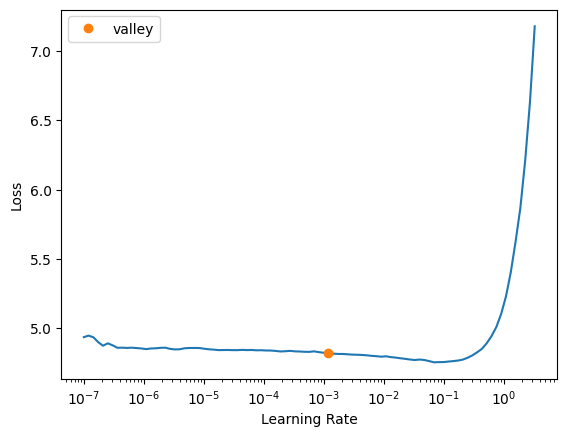

In [ ]:
# find a learning rate
lr = lm_learner.lr_find()

In [ ]:
# fit one cycle
lm_learner.fit_one_cycle(1, lr.valley)

epoch,train_loss,valid_loss,accuracy,time
0,4.300612,4.152939,0.278306,08:18


In [ ]:
# save the encoder
lm_learner.save_encoder("model")

In [ ]:
lm_learner.predict("this movie talks about Canadian", n_words=20)

'this movie talks about Canadian politics with a profound answer to what skipping docks , in Americans watched them to live from the flow'

In [ ]:
clas_learner = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.5, metrics = accuracy)
clas_learner.load_encoder('model')

epoch,train_loss,valid_loss,accuracy,time
0,0.394632,0.334588,0.855400,01:45
1,0.371869,0.328119,0.860200,01:44
2,0.360831,0.327925,0.861400,01:44


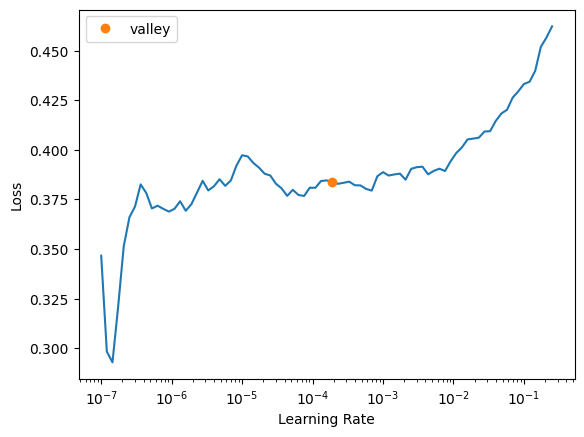

In [ ]:
# tune the text_classifier_learner to accpetable accuracy (>80%)
lr = clas_learner.lr_find()
clas_learner.fit_one_cycle(3, lr.valley)

In [ ]:
clas_learner.predict("This is a horrible movie.")

('positive', tensor(1), tensor([0.0313, 0.9687]))

In [ ]:
clas_learner.predict("This is a great movie,")

('positive', tensor(1), tensor([9.3802e-06, 9.9999e-01]))

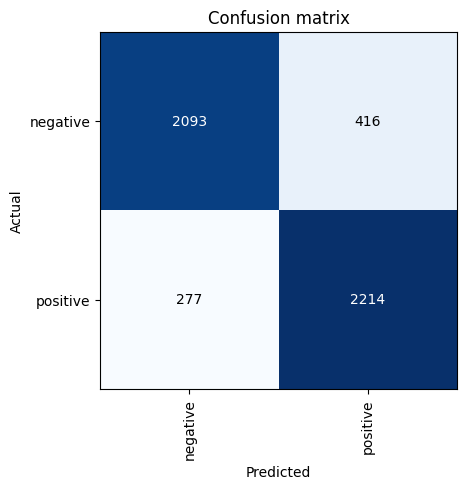

In [ ]:
interp = ClassificationInterpretation.from_learner(
    clas_learner,
    ds_idx = 1
)
interp.plot_confusion_matrix()

In [ ]:
import pandas as pd

# read test data from csv
df = pd.read_csv(path + "/test.csv")
# get true labels as a tensor of integers
y_true = tensor(df["sentiment"]=="positive").int()

In [ ]:
# get predictions on test data
test_dl = data_clas.test_dl(df['review'])
clas_learner.dls.test_dl = test_dl
preds, _ = clas_learner.get_preds(dl=test_dl)
pred_labels = preds.argmax(dim=1)

In [ ]:
# calculate test accuracy
correct = y_true == pred_labels
acc = sum(correct)/len(correct)

In [ ]:
# print model test accuracy
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.8636
